## Assignment: Image recognition
- Alumno 1: José Antonio Ruiz Heredia
- Alumno 2: Álvaro Honrubia
- Alumno 3: Hector Carlos Flores Reynoso 

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/4oNHlRFEd71HXp4](https://drive.upm.es/s/4oNHlRFEd71HXp4)

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2025-04-10 23:08:52.044552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744326532.066903     336 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744326532.073935     336 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [3]:
categories = {0: 'Cargo plane', 1: 'Helicopter', 2: 'Small car', 3: 'Bus', 4: 'Truck', 5: 'Motorboat', 6: 'Fishing vessel', 7: 'Dump truck', 8: 'Excavator', 9: 'Building', 10: 'Storage tank', 11: 'Shipping container'}

In [4]:
!pip install rasterio

In [5]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open('../input/xview-recognition/xview_recognition/'+filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

#### Training
Design and train a CNN to deal with the “xview_recognition” classification task.

In [6]:
import json

# Load database
json_file = '../input/xview-recognition/xview_recognition/xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [7]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Helicopter': 70, 'Small car': 4290, 'Bus': 2155, 'Truck': 2746, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 4689, 'Storage tank': 1469, 'Shipping container': 1523}


In [8]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)
print('Number of training images: ' + str(len(anns_train)))
print('Number of validation images: ' + str(len(anns_valid)))

Number of training images: 19239
Number of validation images: 2138


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, ReLU, LeakyReLU
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import L2

model = Sequential()

###################################
# Convolutional Feature Extractor #
###################################
model.add(Conv2D(32,(1,1),strides=(1,1),padding="same",kernel_initializer=HeNormal(),input_shape=(224, 224, 3)))
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(2,2)))

for filters in [64, 128, 256, 256, 512, 512]:
    model.add(Conv2D(filters,(3,3),strides=(1,1),padding="same",kernel_initializer=HeNormal()))
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,2)))


# Replace Flatten with GlobalAveragePooling
# Global Average Pooling instead of Flatten
model.add(GlobalAveragePooling2D())


##########################
# Fully Connected Layers #
##########################
for units, dropout_rate in [(512, 0.6), (256, 0.5), (128, 0.4), (64, 0.3)]:
    model.add(Dense(units, kernel_initializer=HeNormal(), kernel_regularizer=L2(1e-4)))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    

# Output layer
model.add(Dense(len(categories),activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1744326539.399294     336 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 7, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,957,452 (18.91 MB)

 Trainable params: 4,955,532 (18.90 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [10]:
from tensorflow.keras.optimizers import Adam

## Learning rate is changed (0.0005)
## beta 1: controls the exponential decay rate for the 1st moment (0.8)
## beta 2: controls the 2nd moment decay, fine-tuned for specific tasks. (0.999)
## epsilon: avoid numerical instability (1e-9)

opt = Adam(learning_rate=5e-4, beta_1=0.8, beta_2=0.999, epsilon=1e-9, amsgrad=True, clipnorm=1.0)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
## Change the factor to 0.5 and patience to 5 to make the learning rate decrease.
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.5, patience=5, verbose=1)
## Reduce the patience to stop early if the model doesn’t improve
early_stop = EarlyStopping('val_accuracy', patience=50, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data aumentation
datagen = ImageDataGenerator(
    rotation_range=30,                # Rotation
    width_shift_range=0.2,            # Horizontal shifts
    height_shift_range=0.2,           # Vertical shifts
    shear_range=0.2,                  # Shearing for more distortion
    zoom_range=0.2,                   # Zoom
    fill_mode='nearest'               
)


In [13]:
def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                image = load_geoimage(filename)
                # Apply data augmentation
                image = datagen.random_transform(image)  
                # Prepare the label
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
                # Append image
                images.append(image)
                
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [14]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 32 ## Decreased bach size (32) 
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

In [15]:
import math
import numpy as np

print('Training model')
epochs = 150 ## Increase epochs (150) 
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)
h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model
Epoch 1/150


I0000 00:00:1744326550.339835     408 service.cc:148] XLA service 0x7d74a4210530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744326550.339886     408 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744326551.277115     408 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/602 ━━━━━━━━━━━━━━━━━━━━ 3:01:49 18s/step - accuracy: 0.0938 - loss: 3.8548

I0000 00:00:1744326559.667905     408 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


602/602 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.1267 - loss: 3.0969
Epoch 1: val_accuracy improved from -inf to 0.24088, saving model to model.keras
602/602 ━━━━━━━━━━━━━━━━━━━━ 316s 495ms/step - accuracy: 0.1267 - loss: 3.0964 - val_accuracy: 0.2409 - val_loss: 2.4066 - learning_rate: 5.0000e-04
Epoch 2/150
602/602 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.2753 - loss: 2.3794
Epoch 2: val_accuracy improved from 0.24088 to 0.26660, saving model to model.keras
602/602 ━━━━━━━━━━━━━━━━━━━━ 269s 448ms/step - accuracy: 0.2753 - loss: 2.3791 - val_accuracy: 0.2666 - val_loss: 2.4795 - learning_rate: 5.0000e-04
Epoch 3/150
602/602 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.3913 - loss: 1.9882
Epoch 3: val_accuracy improved from 0.26660 to 0.43452, saving model to model.keras
602/602 ━━━━━━━━━━━━━━━━━━━━ 266s 442ms/step - accuracy: 0.3913 - loss: 1.9881 - val_accuracy: 0.4345 - val_loss: 1.8131 - learning_rate: 5.0000e-04
Epoch 4/150
602/602 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms

#### Validation
Compute validation metrics.

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

In [17]:
import numpy as np

model.load_weights('/kaggle/working/model.keras')
y_true, y_pred = [], []
for ann in anns_valid:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

/tmp/ipykernel_336/956665539.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


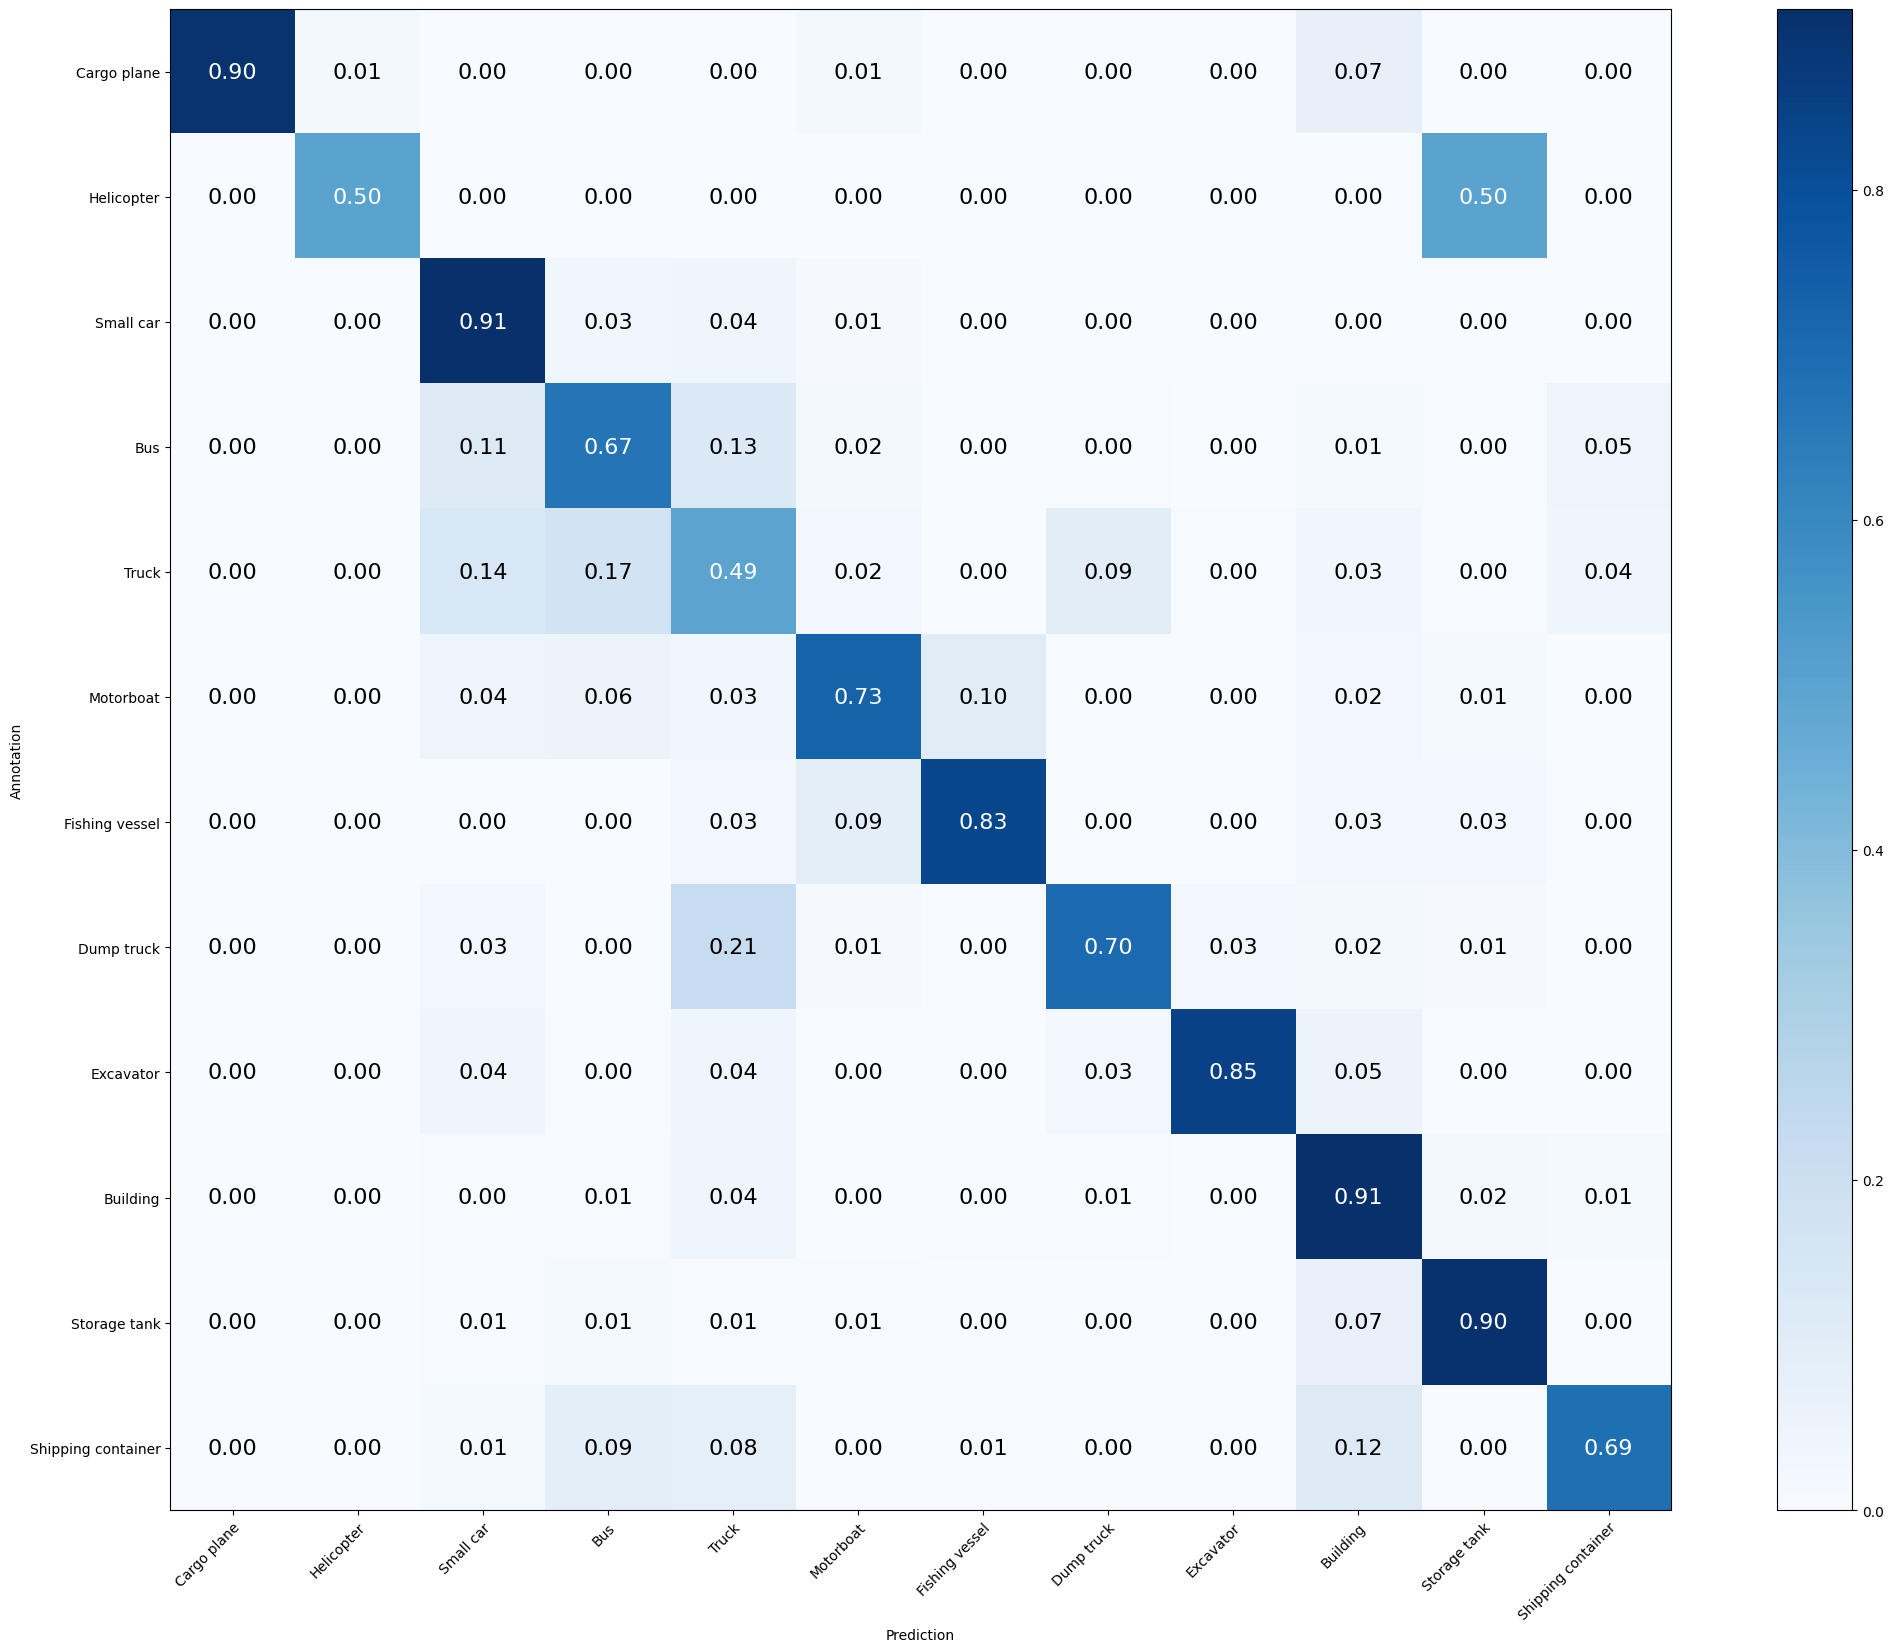

In [18]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [19]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 79.233%
Mean Recall: 75.668%
Mean Precision: 77.523%
> Cargo plane: Recall: 89.706% Precision: 98.387% Specificity: 99.952% Dice: 93.846%
> Helicopter: Recall: 50.000% Precision: 50.000% Specificity: 99.953% Dice: 50.000%
> Small car: Recall: 90.952% Precision: 83.224% Specificity: 95.518% Dice: 86.917%
> Bus: Recall: 67.123% Precision: 63.913% Specificity: 95.675% Dice: 65.479%
> Truck: Recall: 49.434% Precision: 54.357% Specificity: 94.127% Dice: 51.779%
> Motorboat: Recall: 73.034% Precision: 73.034% Specificity: 98.829% Dice: 73.034%
> Fishing vessel: Recall: 83.117% Precision: 84.211% Specificity: 99.418% Dice: 83.660%
> Dump truck: Recall: 70.085% Precision: 71.930% Specificity: 98.417% Dice: 70.996%
> Excavator: Recall: 84.615% Precision: 92.958% Specificity: 99.757% Dice: 88.591%
> Building: Recall: 90.927% Precision: 88.955% Specificity: 96.590% Dice: 89.930%
> Storage tank: Recall: 90.196% Precision: 89.610% Specificity: 99.194% Dice: 89.902%
> Shipping contain

#### Testing
Try to improve the results provided in the competition.

In [20]:
import os
import numpy as np

anns = []
for (dirpath, dirnames, filenames) in os.walk('../input/xview-recognition/xview_recognition/xview_test'):
    for filename in filenames:
        image_path = os.path.relpath(os.path.join(dirpath, filename), '../input/xview-recognition/xview_recognition/')
        image = GenericImage(image_path)
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = dirpath[dirpath.rfind('/')+1:]
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

Number of testing images: 2635


In [21]:
import numpy as np

model.load_weights('/kaggle/working/model.keras')
predictions_data = {"images": {}, "annotations": {}}
for idx, ann in enumerate(anns):
    image_data = {"image_id": ann.filename.split('/')[-1], "filename": ann.filename, "width": int(ann.tile[2]), "height": int(ann.tile[3])}
    predictions_data["images"][idx] = image_data
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        annotation_data = {"image_id": ann.filename.split('/')[-1], "category_id": pred_category, "bbox": [int(x) for x in obj_pred.bb]}
        predictions_data["annotations"][idx] = annotation_data

In [22]:
with open("/kaggle/working/prediction.json", "w") as outfile:
    json.dump(predictions_data, outfile)

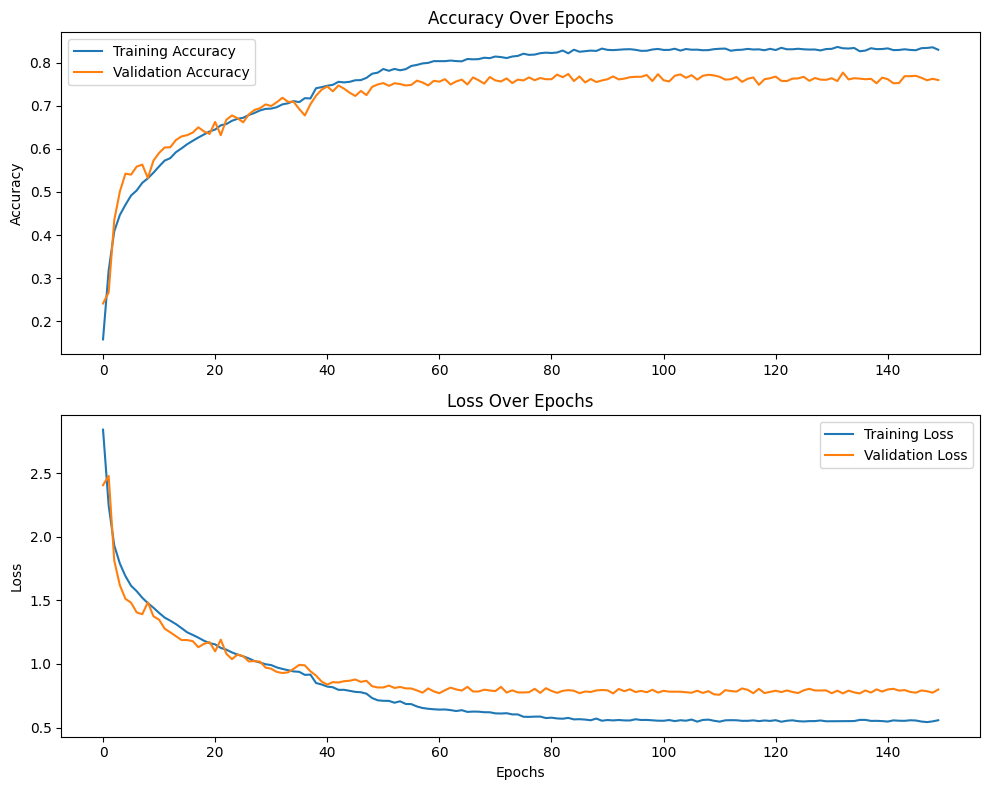

In [23]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy/loss
plt.figure(figsize=(10, 8))

# Accuracy
plt.subplot(2, 1, 1)
plt.plot(h.history['accuracy'], label='Training Accuracy')
plt.plot(h.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss
plt.subplot(2, 1, 2)
plt.plot(h.history['loss'], label='Training Loss')
plt.plot(h.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()